# --------------------------------RICE LEAF DISEASE PROJECT---------------------------------

## Business Case :
    To predict the disease present in the rice leaf using images.

## Domain Analysis:
### Bacterial leaf blight : 
- rice bacterial blight, also called bacterial blight of rice, deadly bacterial disease that is among the most destructive afflictions of cultivated rice (Oryza sativa and O. glaberrima). In severe epidemics, crop loss may be as high as 75 percent, and millions of hectares of rice are infected annually.
### Brown spot :
- Brown spot is a fungal disease that infects the coleoptile(protective sheath covering the leaf), leaves, leaf sheath, panicle branches, glumes(outer husk surrounding the grain), and spikelets. 
- Its most observable damage is the numerous big spots on the leaves which can kill the whole leaf. When infection occurs in the seed, unfilled grains or spotted or discolored seeds are formed
### Leaf smut :
- Leaf smut, caused by the fungus Entyloma oryzae, is a widely distributed, but somewhat minor, disease of rice. The fungus produces slightly raised, angular, black spots (sori) on both sides of the leaves (Figure 1). Although rare, it also can produce spots on leaf sheaths.

### Extracting the images from a zipped file -

In [1]:
import zipfile
with zipfile.ZipFile("PRCP-1001-RiceLeaf.zip", 'r') as zip_ref:
    zip_ref.extractall("")

with zipfile.ZipFile("Data\Bacterial leaf blight-20200814T055237Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall("Data")

with zipfile.ZipFile("Data\Brown spot-20200814T055208Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall("Data")
    
with zipfile.ZipFile("Data\Leaf smut-20200814T055530Z-001.zip", 'r') as zip_ref:
    zip_ref.extractall("Data")



### Renaming files by category wise -

In [2]:
count = 1
for category in ("Bacterial leaf blight", "Brown spot", "Leaf smut"):
    list = os.listdir("Data\{}".format(category))
    for files in list:
        os.rename(src="Data\{}\{}".format(category, files), 
                  dst="Data\{}\{}.{}.JPG".format(category, category, count))
        if category == "Brown spot" and files == list[0]:
            count=0
        elif category == "Leaf smut" and files == list[0]:
            count=0
        count+=1

NameError: name 'os' is not defined

### Splitting the data into train, test and validation sets -

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("Data", output="output", ratio=(0.6,0.2,0.2))
import shutil
shutil.rmtree("Data")

### Building the model -

In [13]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Activation,Dense,Flatten,Rescaling,Dropout,BatchNormalization
model = Sequential([keras.Input(shape=(250, 250, 3)),
                    Rescaling(1./255),
                    Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=2, strides=2),
                    Dropout(0.5),
                    Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=2, strides=2),
                    Dropout(0.5),
                    Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=2, strides=2),
                    Dropout(0.5),
                    Flatten(),
                    Dense(units=3, activation="softmax")
])

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 250, 250, 32)      896       
                                                                 
 batch_normalization_3 (Batc  (None, 250, 250, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 125, 125, 32)     0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 125, 125, 32)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 125, 125, 64)     

### Configuring model for training -

In [15]:
import tensorflow
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Data preprocessing -
Using image_dataset_from_directory to read images

In [16]:
import pathlib
dir = pathlib.Path("output")
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(dir / "train",
                                            image_size=(250,250),
                                            batch_size=32)
validation_dataset = image_dataset_from_directory(dir / "val",
                                                  image_size=(250,250),
                                                  batch_size=32)
test_dataset = image_dataset_from_directory(dir / "test",
                                            image_size=(250,250),
                                            batch_size=32)

Found 71 files belonging to 3 classes.
Found 23 files belonging to 3 classes.
Found 25 files belonging to 3 classes.


### Data visualization -

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


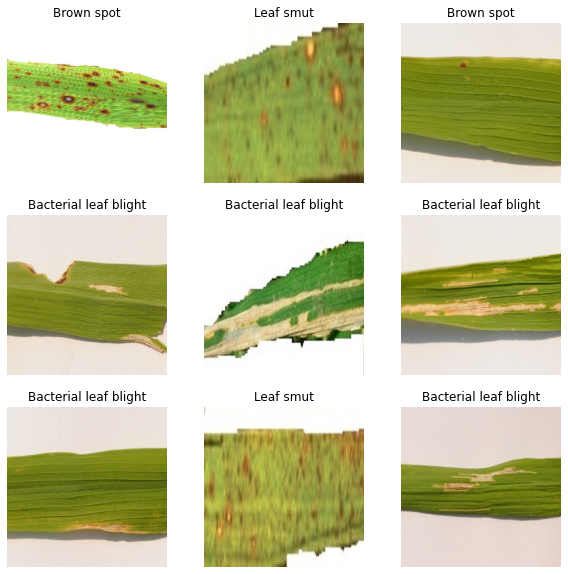

In [17]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


### Fitting the model -

In [18]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="callback",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(train_dataset, epochs= 20,
                    validation_data=validation_dataset,
                    callbacks=callbacks, verbose=2)

Epoch 1/15


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


INFO:tensorflow:Assets written to: callback\assets
3/3 - 16s - loss: 15.8427 - accuracy: 0.3239 - val_loss: 2.8612 - val_accuracy: 0.3478 - 16s/epoch - 5s/step
Epoch 2/15
INFO:tensorflow:Assets written to: callback\assets
3/3 - 15s - loss: 43.5258 - accuracy: 0.3803 - val_loss: 0.9310 - val_accuracy: 0.4783 - 15s/epoch - 5s/step
Epoch 3/15
INFO:tensorflow:Assets written to: callback\assets
3/3 - 13s - loss: 9.1191 - accuracy: 0.5211 - val_loss: 0.8513 - val_accuracy: 0.6522 - 13s/epoch - 4s/step
Epoch 4/15
3/3 - 11s - loss: 8.3640 - accuracy: 0.6620 - val_loss: 0.9084 - val_accuracy: 0.4783 - 11s/epoch - 4s/step
Epoch 5/15
3/3 - 11s - loss: 8.6155 - accuracy: 0.5775 - val_loss: 1.3442 - val_accuracy: 0.3478 - 11s/epoch - 4s/step
Epoch 6/15
3/3 - 12s - loss: 6.4013 - accuracy: 0.6197 - val_loss: 1.5026 - val_accuracy: 0.4348 - 12s/epoch - 4s/step
Epoch 7/15
3/3 - 11s - loss: 3.0641 - accuracy: 0.7606 - val_loss: 1.6327 - val_accuracy: 0.4348 - 11s/epoch - 4s/step
Epoch 8/15
3/3 - 12s - 

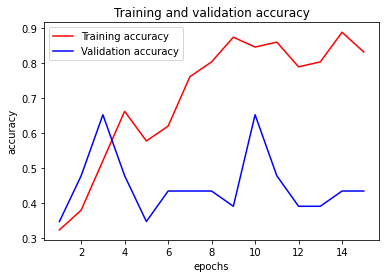

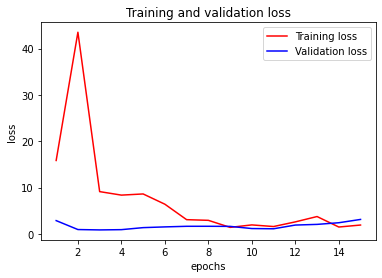

In [19]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [20]:
test_model = keras.models.load_model("callback")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1/1 [==============================] - 1s 1s/step - loss: 0.8652 - accuracy: 0.5600
Test accuracy: 0.560


### By Using Data Augmentation Technique-
Data Augmentation is a technique where we generate multiple images from a single image by using different angle of rotations, by flipping, by zooming, etc. The purpose behind it is nothing but to make our model robust so it can predict very well on any kind of images.Such as image taken from an angle, image which is taken from too close or too far, etc. A model which is not using data augmentation may or may not predict correctly on such kinds of images.
Also as we have seen that our model is overfitting the data. There are two ways to approach an overfit model:
- Reduce overfitting by training the network on more examples.
- Reduce overfitting by changing the complexity of the network.

So for these reasons we are using the data augmentation technique here.

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

data_gen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                              zoom_range=0.2,
                              horizontal_flip=True,
                              vertical_flip=True,
                              fill_mode="nearest")


In [ ]:
import os
for folders in ("train","val", "test"):
    for category in ("Bacterial leaf blight", "Brown spot", "Leaf smut"):
        list = os.listdir("output/{}/{}".format(folders, category))
        for files in list:
            img =load_img("output/{}/{}/{}".format(folders, category, files))
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in data_gen.flow(x, batch_size=1,
                          save_to_dir='output/{}/{}'.format(folders, category),save_prefix='{}.{}'.format(files,i), save_format='jpeg'):
                i += 1
                if i > 500:
                    break

### Now Let's load the directories of images -

In [54]:
import pathlib
dir = pathlib.Path("output")
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(dir / "train",
                                            image_size=(250,250),
                                            batch_size=32)
validation_dataset = image_dataset_from_directory(dir / "val",
                                                  image_size=(250,250),
                                                  batch_size=32)
test_dataset = image_dataset_from_directory(dir / "test",
                                            image_size=(250,250),
                                            batch_size=32)

Found 34975 files belonging to 3 classes.
Found 11658 files belonging to 3 classes.
Found 11660 files belonging to 3 classes.


### Checking the images randomly inside the train dataset -

['Bacterial leaf blight', 'Brown spot', 'Leaf smut']


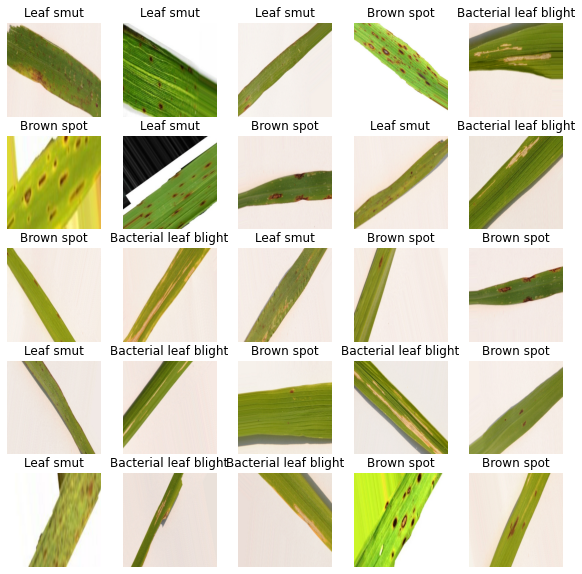

In [2]:
import matplotlib.pyplot as plt

class_names = train_dataset.class_names
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
      for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Again creating a model -

In [67]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(250, 250, 3))
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.8)(x)
outputs = layers.Dense(3, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### Compiling the model  -

In [68]:
import tensorflow
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Checking the model summary -

In [69]:
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 rescaling_7 (Rescaling)     (None, 250, 250, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 250, 250, 32)      896       
                                                                 
 batch_normalization_43 (Bat  (None, 250, 250, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 125, 125, 32)     0         
 g2D)                                                            
                                                                 
 dropout_44 (Dropout)        (None, 125, 125, 32)      0   

### Training the model -

In [71]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="callback",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(train_dataset, epochs= 20,
                    validation_data=validation_dataset,
                    callbacks=callbacks, verbose=2)

Epoch 1/15
INFO:tensorflow:Assets written to: callback\assets
1102/1102 - 7495s - loss: 0.5703 - accuracy: 0.7764 - val_loss: 4.1958 - val_accuracy: 0.4108 - 7495s/epoch - 7s/step
Epoch 2/15
1102/1102 - 8586s - loss: 0.1258 - accuracy: 0.9556 - val_loss: 6.1083 - val_accuracy: 0.3549 - 8586s/epoch - 8s/step
Epoch 3/15
INFO:tensorflow:Assets written to: callback\assets
1102/1102 - 7821s - loss: 0.0807 - accuracy: 0.9733 - val_loss: 1.9225 - val_accuracy: 0.6322 - 7821s/epoch - 7s/step
Epoch 4/15
1102/1102 - 7083s - loss: 0.0553 - accuracy: 0.9827 - val_loss: 2.2051 - val_accuracy: 0.6902 - 7083s/epoch - 6s/step
Epoch 5/15
1102/1102 - 8287s - loss: 0.0454 - accuracy: 0.9854 - val_loss: 1.9627 - val_accuracy: 0.6992 - 8287s/epoch - 8s/step
Epoch 6/15
1102/1102 - 7524s - loss: 0.0324 - accuracy: 0.9904 - val_loss: 3.3836 - val_accuracy: 0.5629 - 7524s/epoch - 7s/step
Epoch 7/15
INFO:tensorflow:Assets written to: callback\assets
1102/1102 - 8120s - loss: 0.0270 - accuracy: 0.9914 - val_loss

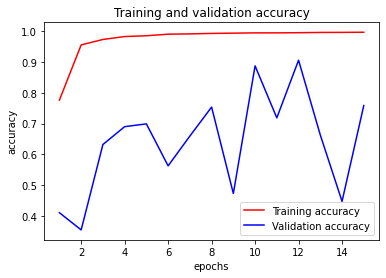

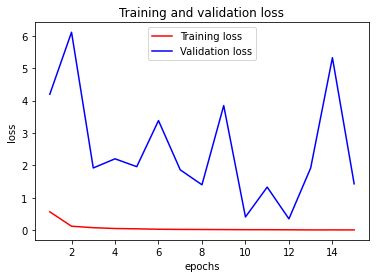

In [72]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [73]:
test_model = keras.models.load_model("callback")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


362/362 [==============================] - 534s 1s/step - loss: 0.0493 - accuracy: 0.9807
Test accuracy: 0.981


### Using Transfer Learning Method -

Transfer learning is a technique to help solve this problem. As a concept, it works by transferring as much knowledge as possible from an existing model to a new model designed for a similar task. For example, transferring the more general aspects of a model which make up the main processes for completing a task.

In [10]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet', include_top=False, input_shape=(250,250,3))

In [11]:
from tensorflow.keras import Model 
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

for layer in model.layers[:-15]:
    layer.trainable = False

x = model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
output  = Dense(3, activation='softmax')(x)
model = Model(model.input, output)


In [12]:
import tensorflow
model.compile(optimizer='adam',
              loss=tensorflow.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 250, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 125, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [14]:
import keras
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="callback.keras",
    save_best_only=True,
    monitor="val_loss")]

history = model.fit(train_dataset, epochs= 20,
                    validation_data=validation_dataset,
                    callbacks=callbacks, verbose=2)

Epoch 1/20


C:\Users\HP\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
C:\Users\HP\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1102/1102 - 8643s - loss: 0.0390 - accuracy: 0.9890 - val_loss: 0.7215 - val_accuracy: 0.8792 - 8643s/epoch - 8s/step
Epoch 2/20
1102/1102 - 8609s - loss: 0.0128 - accuracy: 0.9966 - val_loss: 0.6687 - val_accuracy: 0.8780 - 8609s/epoch - 8s/step
Epoch 3/20
1102/1102 - 8603s - loss: 0.0061 - accuracy: 0.9984 - val_loss: 0.9832 - val_accuracy: 0.8860 - 8603s/epoch - 8s/step
Epoch 4/20
1102/1102 - 8613s - loss: 0.0045 - accuracy: 0.9990 - val_loss: 1.4198 - val_accuracy: 0.8616 - 8613s/epoch - 8s/step
Epoch 5/20
1102/1102 - 8649s - loss: 0.0025 - accuracy: 0.9990 - val_loss: 1.0479 - val_accuracy: 0.8766 - 8649s/epoch - 8s/step
Epoch 6/20
1102/1102 - 9143s - loss: 0.0154 - accuracy: 0.9976 - val_loss: 1.3935 - val_accuracy: 0.8610 - 9143s/epoch - 8s/step
Epoch 7/20
1102/1102 - 9480s - loss: 7.8723e-04 - accuracy: 0.9997 - val_loss: 2.3959 - val_accuracy: 0.8250 - 9480s/epoch - 9s/step
Epoch 8/20
1102/1102 - 9000s - loss: 0.0013 - accuracy: 0.9998 - val_loss: 1.3941 - val_accuracy: 0.8713

### Checking the graphs of accuracy and loss with respect to number of epochs -

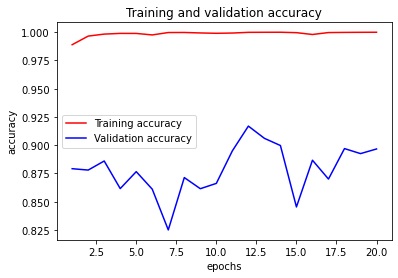

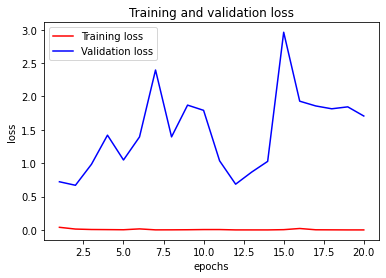

In [15]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "r", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "r", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

### Evaluating model on test data -

In [70]:
test_model = keras.models.load_model("callback")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

362/362 [==============================] - 539s 1s/step - loss: 0.5764 - accuracy: 0.8711
Test accuracy: 0.871


### Saving the model for Deployment -

In [17]:
# Saving the model for Future Inferences

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")

C:\Users\HP\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


### Loading the saved model and checking it for predictions -

In [1]:
from keras.models import model_from_json

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [2]:
loaded_model

### Checking Prediction on some new Images -

In [3]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image  import image
import numpy as np

def preprocess_img(img_path, img_size):
    img = image.load_img(img_path, target_size=img_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    features = loaded_model.predict(x)
    return features

In [20]:
features = preprocess_img("output/test/Bacterial leaf blight/Bacterial leaf blight.9.JPG.0_0_4508.jpeg", (250,250))

In [21]:
if features[0][0] > features[0][1] and features[0][0] > features[0][2]:
    print("Bacterial Leaf Blight")
elif features[0][1] > features[0][0] and features[0][1] > features[0][2]:
    print("Brown Spot")
else:
    print("Leaf Smut")

Bacterial Leaf Blight


### Conclusion -

- Here we got a pretty good performance. We can improve this by training it on more number of epochs.

- Here we can do one more thing in order to reduce the loss or overfitting - 
Here we should supposely to apply the data augmentation technique before splitting the image dataset into train, test and validation. So it will not get different kind of data in train, test and validation datasets.

# --------------------------------------------Thank You !------------------------------------------------